## Elliptic Tracker

Реализованный детектор задаётся уравнением

$$\frac{x^2}{R_x^2} + \frac{y^2}{R_y^2} + \frac{z^2}{R_z^2} = 1$$

In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
import pythiamill as pm

In [2]:
param_names = [
  "TimeShower:alphaSvalue",
  # "TimeShower:pTmin",
  # "TimeShower:pTminChgQ",

  # "StringPT:sigma",
  # "StringZ:bLund",
  # "StringZ:aExtraSQuark",
  # "StringZ:aExtraDiquark",
  # "StringZ:rFactC",
  # "StringZ:rFactB",

  "StringFlav:probStoUD",
  "StringFlav:probQQtoQ",
  "StringFlav:probSQtoQQ",
  "StringFlav:probQQ1toQQ0",
  "StringFlav:mesonUDvector",
  "StringFlav:mesonSvector",
  "StringFlav:mesonCvector",
  "StringFlav:mesonBvector",
  "StringFlav:etaSup",
  "StringFlav:etaPrimeSup",
  "StringFlav:decupletSup"
]

monash = np.array([
  0.1365,
  # 0.5,
  # 0.5,

  # 0.98,
  # 0.335,
  # 0,
  # 0.97,
  # 1.32,
  # 0.885,

  0.217,
  0.081,
  0.915,
  0.0275,
  0.6,
  0.12,
  1,
  0.5,
  0.55,
  0.88,
  2.2
])

In [3]:
options = pm.config.monash + pm.config.please_be_quiet + [
  '%s = %lf' % (k, v)
  for k, v in zip(param_names, monash)
]

In [4]:
def get_spherical_tracker(R=1.):
    detector = pm.utils.SphericalTracker(
        is_binary=False, photon_detection=True,
        pseudorapidity_steps=32, phi_steps=32,
        n_layers=1, R_min=R, R_max=R,
    )
    
    return detector


def get_elliptic_tracker(Rx=1., Ry=1., Rz=1.):
    detector = pm.utils.EllipticTracker(
        is_binary=False, photon_detection=True,
        pseudorapidity_steps=32, phi_steps=32, 
        Rx=Rx, Ry=Ry, Rz=Rz,
    )

    return detector
    
    
def get_mill(detector):
    mill = pm.ParametrizedPythiaMill(
        detector_factory=detector,
        options=options,
        batch_size=1,
        n_workers=8,
        seed=111,
        log=None
    )
    
    return mill

In [5]:
def get_experiment_result(mill):
    
    def get_data(params, n_samples):
        params = np.array(params, dtype='float32')
        assert params.shape == (3, )

        for _ in range(n_samples):
            mill.request(params)

        results = []
        for _ in range(n_samples): # tqdm(range(n_samples)):
            ps, batch = mill.retrieve()
            batch = batch.reshape((batch.shape[0], 1, 32, 32))
            results.append(batch)

        return np.concatenate(results, axis=0)
    
    X_ground_truth = get_data([0.0, 0.0, 0.0], 32 * 1024)
    X_x = get_data([OFFSET, 0.0, 0.0], 32 * 1024)
    X_y = get_data([0.0, OFFSET, 0.0], 32 * 1024)
    X_z = get_data([0.0, 0.0, OFFSET], 32 * 1024)
    
    return X_ground_truth, X_x, X_y, X_z
    
    
def plot_experiment_result(X_ground_truth, X_x, X_y, X_z, suptitle=None):
    size = 3
    space = 0.5
    plt.subplots(nrows=1, ncols=4, figsize=(4 * size + 3 * space, 1 * size + space))
    plt.subplot(1, 4, 1)
    plt.axis('off')
    plt.title(f'no offset')
    plt.imshow(np.mean(X_ground_truth, axis=(0, 1)))
    plt.subplot(1, 4, 2)
    plt.axis('off')
    plt.title(f'offset x={OFFSET}')
    plt.imshow(np.mean(X_x, axis=(0, 1)))
    plt.subplot(1, 4, 3)
    plt.axis('off')
    plt.title(f'offset y={OFFSET}')
    plt.imshow(np.mean(X_y, axis=(0, 1)))
    plt.subplot(1, 4, 4)
    plt.axis('off')
    plt.title(f'offset z={OFFSET}')
    plt.imshow(np.mean(X_z, axis=(0, 1)))
    plt.suptitle(suptitle, fontsize=16)
    plt.show()

In [6]:
def main(kind='spherical', **kwargs):    
    if kind == 'spherical':
        detector = get_spherical_tracker(**kwargs)
        suptitle = fr"spherical R={kwargs['R']}"
    elif kind == 'elliptic':
        detector = get_elliptic_tracker(**kwargs)
        suptitle = fr"elliptic $R_x$={kwargs['Rx']} $R_y$={kwargs['Ry']} $R_z$={kwargs['Rz']}"
    mill = get_mill(detector)
    X_ground_truth, X_x, X_y, X_z = get_experiment_result(mill)
    plot_experiment_result(X_ground_truth, X_x, X_y, X_z, suptitle)

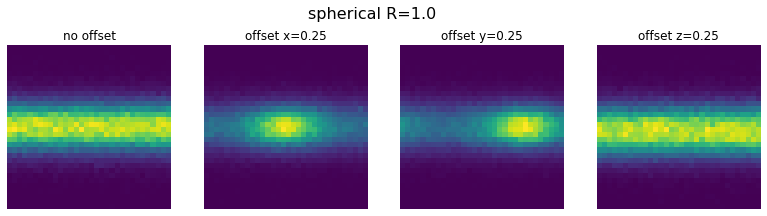

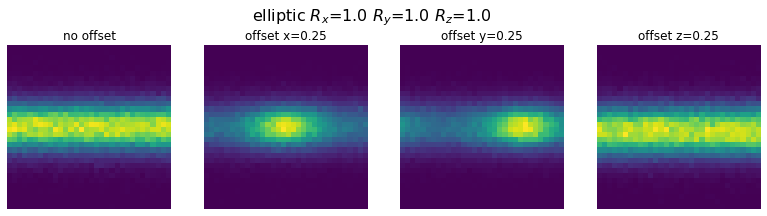

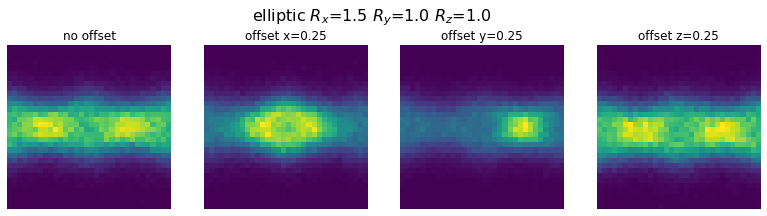

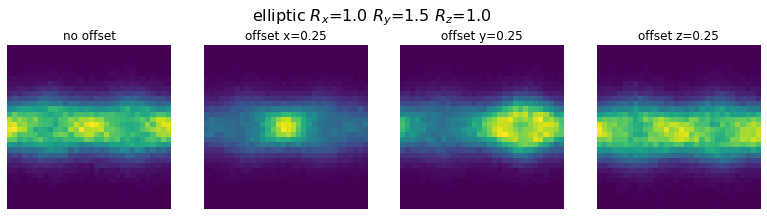

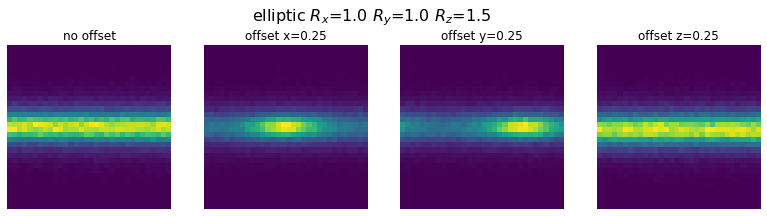

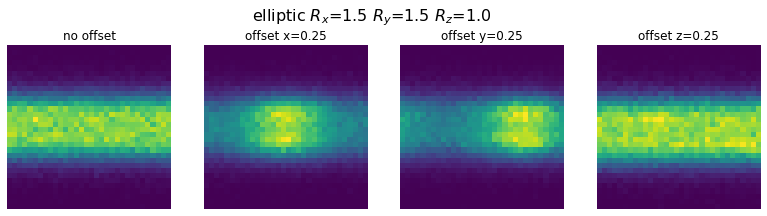

In [7]:
OFFSET = 0.25
main(kind='spherical', R=1.)
main(kind='elliptic', Rx=1., Ry=1., Rz=1.)
main(kind='elliptic', Rx=1.5, Ry=1., Rz=1.)
main(kind='elliptic', Rx=1., Ry=1.5, Rz=1.)
main(kind='elliptic', Rx=1., Ry=1., Rz=1.5)
main(kind='elliptic', Rx=1.5, Ry=1.5, Rz=1.)